In [2]:
import scanpy as sc
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt

In [2]:
import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri
%load_ext rpy2.ipython
anndata2ri.activate()

ModuleNotFoundError: No module named 'rpy2'

In [3]:
## set parameters for visualisation

sc.settings.set_figure_params(dpi=80)

# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')

In [2]:
count_mat = []
genes = []
with open("/home/mrichter/zonation_paper/GSE124395_Normalhumanlivercellatlasdata.txt") as f:
    cell_names = f.readline()
    cell_names = cell_names.split("\t")
    for line in f:
        line = line.split("\t")
        count_mat.append(line[1:])
        genes.append(line[0])

KeyboardInterrupt: 

In [3]:
## transform the raw count matrix to be in a data format compatible with AnnData
count_mat = np.array(count_mat)
count_mat = count_mat.transpose()
count_mat.shape

(12622, 33941)

In [4]:
adata = ad.AnnData(count_mat, 
                   obs=pd.DataFrame(index=cell_names),
                   var=pd.DataFrame(index=genes))

In [5]:
del count_mat

In [6]:
cell = {}
with open("/home/mrichter/zonation_paper/cell_type_annotation.txt") as f:
    for line in f:
        line = line.split("\t")
        if len(line) > 1:
            cell[line[0]] = line[1][:-1]

In [7]:
cell_type = []
for i in range(0, len(adata)):
    if adata.obs_names.tolist()[i] in cell.keys():
        cell_type.append(cell[adata.obs_names.tolist()[i]])
    else:
        cell_type.append("NA")
adata.obs["cell_types"] = cell_type

In [8]:
adata.obs["replicate"] = "aizarani2019"

In [9]:
adata

AnnData object with n_obs × n_vars = 12622 × 33941
    obs: 'cell_types', 'replicate'

In [10]:
adata.write("/home/mrichter/zonation_paper/aizarani_ct_mat_raw_dec21.h5ad")

... storing 'cell_types' as categorical
... storing 'replicate' as categorical


In [4]:
adata = ad.read("/home/mrichter/zonation_paper/aizarani_ct_mat_raw_dec21.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 12622 × 33941
    obs: 'cell_types', 'replicate'

In [6]:
names = []
for elem in adata.var_names.tolist():
    names.append(elem[1:-1])
adata.var["gene_name"] = names    

In [7]:
new_names = []
for elem in list(adata.var_names):
    elem = elem.split('"')
    new_names.append(elem[1])
adata.var_names = new_names    

In [8]:
sc.pp.filter_genes(adata, min_cells=1)
sc.pp.filter_genes(adata, min_counts=1)

sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_cells(adata, min_counts=1)

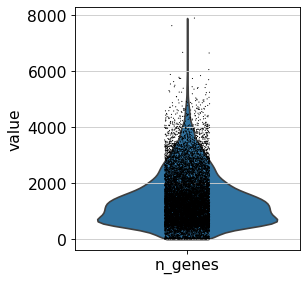

In [9]:
sc.pl.violin(adata, "n_genes")

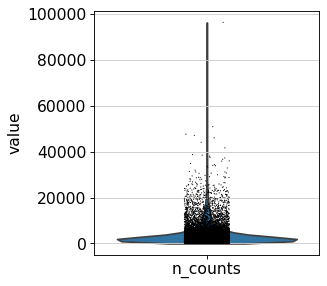

In [10]:
sc.pl.violin(adata, "n_counts")

In [11]:
# remove cells with less than 100 genes covered
adata = adata[adata.obs['n_genes'] > 100, :]
# remove cells with more than 6000 genes covered
adata = adata[adata.obs['n_genes'] < 6000, :]

# remove cells with less than 100 read counts
adata = adata[adata.obs['n_counts'] > 800, :]
# remove cells with more than 30,000 read counts
adata = adata[adata.obs['n_counts'] < 30000, :]

In [12]:
sc.pp.filter_genes(adata, min_cells=10)

Trying to set attribute `.var` of view, copying.


In [145]:
adata

AnnData object with n_obs × n_vars = 11043 × 19416
    obs: 'cell_types', 'replicate', 'n_genes', 'n_counts', 'size_factors', 'n_counts_norm', 'louvain'
    var: 'gene_name', 'n_cells', 'n_counts'
    uns: 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm_counts'
    obsp: 'distances', 'connectivities'

In [14]:
# test_env

In [15]:
%%R
.libPaths("/home/mrichter/miniconda3/envs/test_env/lib/R/library")

In [16]:
%%R
library(scran)
library("org.Hs.eg.db")

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find

In [17]:
data_mat = adata.X.T
#data_mat = data_mat.todense()

In [18]:
%%R -i data_mat -o size_factors

size_factors = computeSumFactors(data_mat, min.mean=0.05)

In [19]:
adata.layers["counts"] = adata.X.copy()

In [20]:
adata.obs["size_factors"] = size_factors

In [21]:
#Normalize adata 
adata.X /= adata.obs['size_factors'].values[:,None]
adata.layers["norm_counts"] = adata.X.copy()
adata.obs["n_counts_norm"] = np.sum(adata.X, axis=1)
sc.pp.log1p(adata)

In [22]:
adata.raw = adata

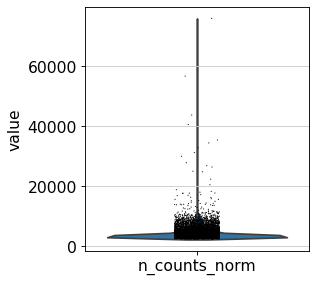

In [23]:
sc.pl.violin(adata, "n_counts_norm")

In [24]:
adata = adata[adata.obs["n_counts_norm"] < 20000]

In [25]:
adata

View of AnnData object with n_obs × n_vars = 11043 × 19416
    obs: 'cell_types', 'replicate', 'n_genes', 'n_counts', 'size_factors', 'n_counts_norm'
    var: 'gene_name', 'n_cells', 'n_counts'
    uns: 'log1p'
    layers: 'counts', 'norm_counts'

In [26]:
adata.write("/home/mrichter/zonation_paper/filtered_scran_normalized_aizarani_jan22.h5ad")

In [2]:
# scgen

In [3]:
adata = ad.read("/home/mrichter/zonation_paper/filtered_scran_normalized_aizarani_jan22.h5ad")

In [4]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.tsne(adata)
sc.tl.umap(adata)

In [5]:
adata

AnnData object with n_obs × n_vars = 11043 × 19416
    obs: 'cell_types', 'replicate', 'n_genes', 'n_counts', 'size_factors', 'n_counts_norm'
    var: 'gene_name', 'n_cells', 'n_counts'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm_counts'
    obsp: 'distances', 'connectivities'

In [7]:
sc.tl.louvain(adata, resolution=0.08)

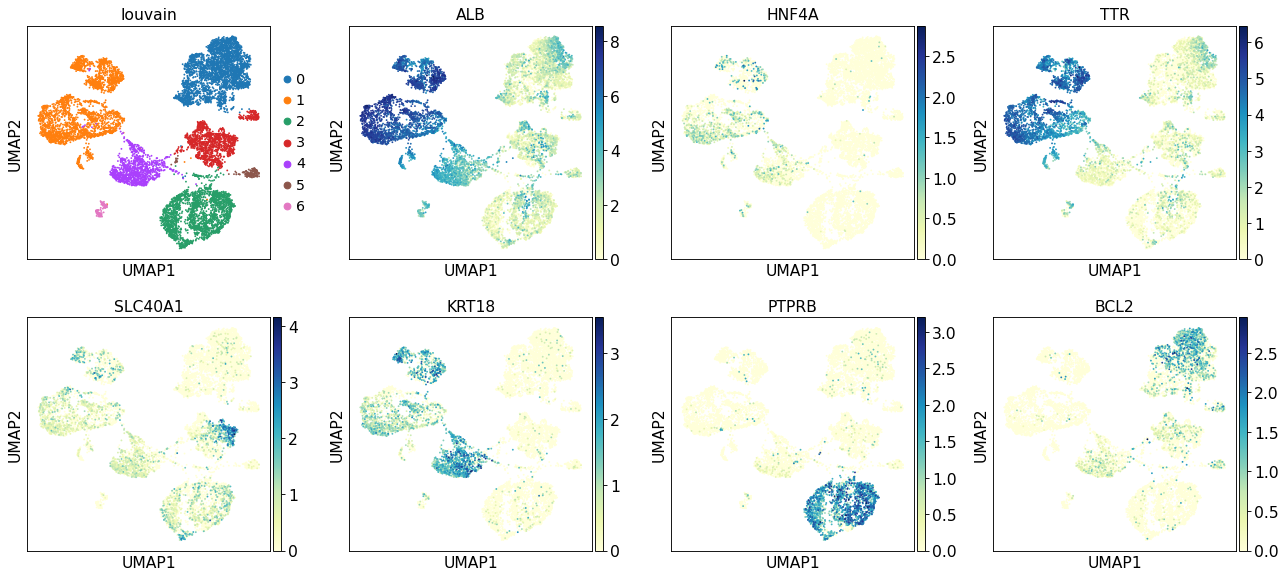

In [8]:
sc.pl.umap(adata, color=["louvain","ALB","HNF4A","TTR","SLC40A1","KRT18","PTPRB","BCL2"])

In [9]:
adataH = adata[adata.obs["louvain"] == "1"]

In [10]:
sc.pp.pca(adataH)
sc.pp.neighbors(adataH)
sc.tl.umap(adataH)

In [183]:
sc.tl.louvain(adataH, resolution=0.2)

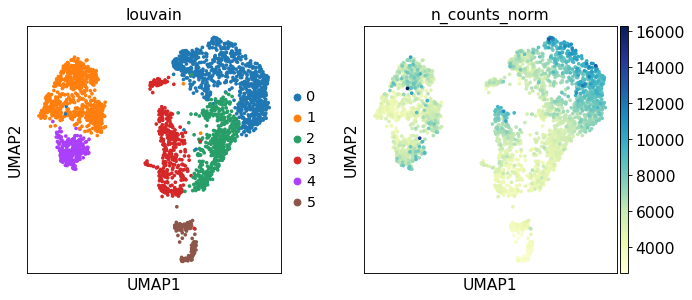

In [184]:
sc.pl.umap(adataH, color=["louvain","n_counts_norm"])

In [164]:
sc.tl.rank_genes_groups(adataH, groupby="louvain", n_genes=500)

In [165]:
genes = {}
for elem in set(adataH.obs["louvain"]):
    genes["aizarani_"+elem] = []
for elem in set(adataH.obs["louvain"]):
    genes["aizarani_"+elem].append(adataH.uns["rank_genes_groups"]["names"][elem].tolist())
for elem in set(adataH.obs["louvain"]):
    genes["aizarani_"+elem] = [item for sublist in genes["aizarani_"+elem] for item in sublist]

In [166]:
df = pd.DataFrame(genes)

In [167]:
df.to_csv("aizarani_louvain02_top500.csv")

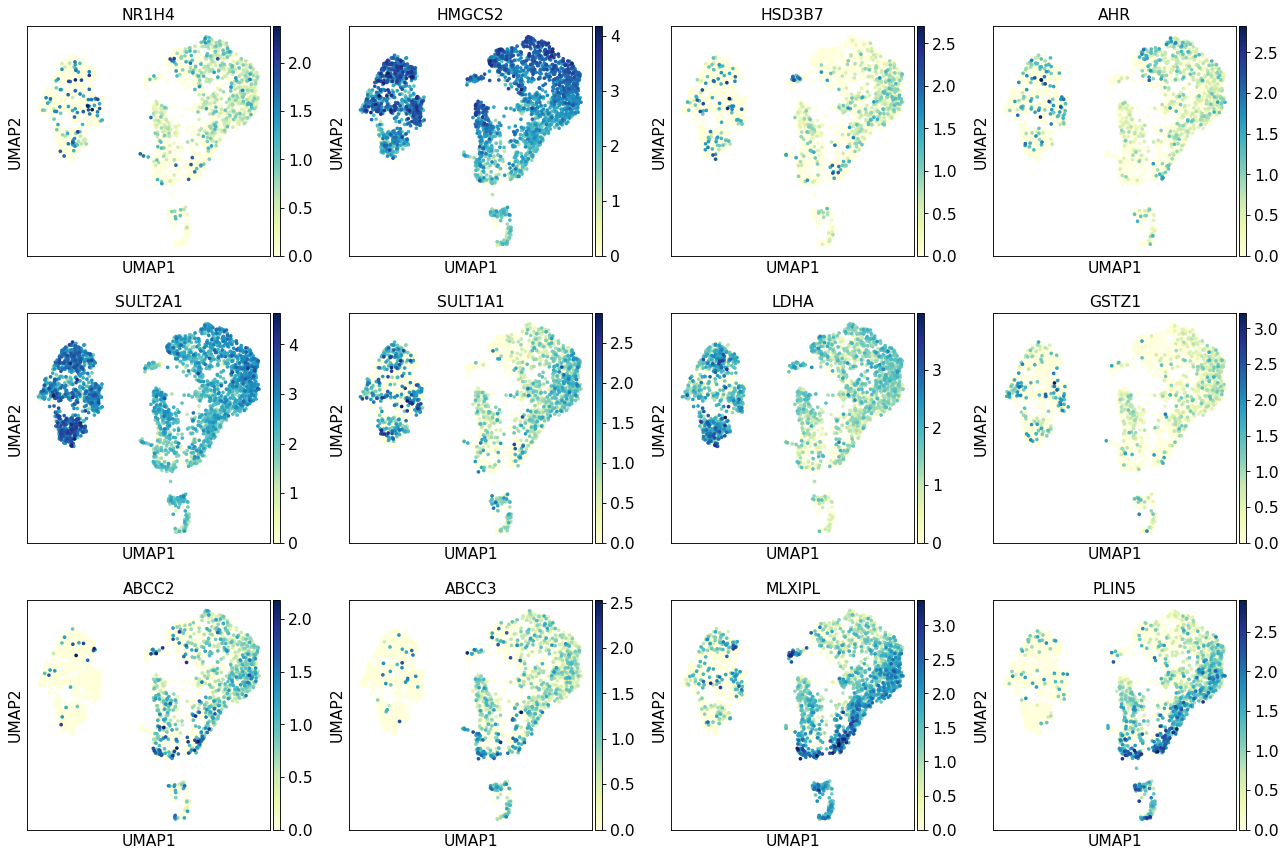

In [148]:
sc.pl.umap(adataH, color=["NR1H4","HMGCS2","HSD3B7","AHR",
                          "SULT2A1","SULT1A1","LDHA","GSTZ1",
                          "ABCC2","ABCC3","MLXIPL","PLIN5"], ncols=4)

In [185]:
annot = []
for elem in adataH.obs["louvain"]:
    if elem in ["1","4"]:
        annot.append("carbs_phaseII_stress")
    elif elem in ["2","3","5"]:
        annot.append("lipids_phaseIII")
    else:
        annot.append("bile_sterols")
adataH.obs["subgroups"] = annot

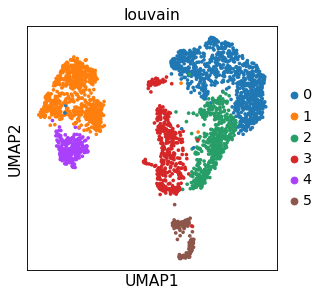

In [43]:
sc.pl.umap(adataH, color="louvain")

In [187]:
adataH.write("/home/hpc/martinez/00_projects/human/precision_toxicology/Dominic_Grun_hepatocytes_normalized_annot_feb22.h5ad")

In [4]:
adataH = ad.read("/home/hpc/martinez/00_projects/human/precision_toxicology/Dominic_Grun_hepatocytes_normalized_annot_feb22.h5ad")

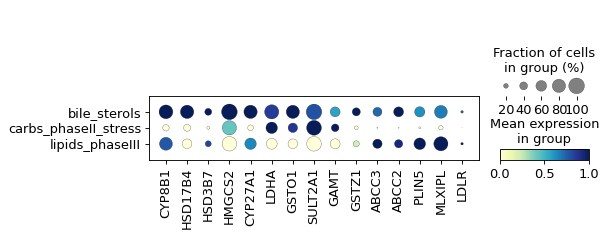

In [5]:
sc.pl.dotplot(adataH, groupby="subgroups", var_names=["CYP8B1","HSD17B4","HSD3B7","HMGCS2","CYP27A1",
                          "LDHA","GSTO1","SULT2A1","GAMT","GSTZ1",
                                                     "ABCC3","ABCC2","PLIN5","MLXIPL","LDLR"],
              cmap="YlGnBu",
              standard_scale="var")
             #save="_aizarani_marker_genes_20220215.pdf")

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('/home/mrichter/zonation_paper/zonation_markers.txt', sep='\t')
zonation_markers = []
for marker in df.HumanGeneID.tolist():
    if ';' in marker:
        zonation_markers += marker.split(';')
    else:
        zonation_markers.append(marker)

In [8]:
bins = 3
labels = [1,2,3]
df['zones'] = pd.cut(df['HumanModule'], bins=bins, labels=labels)

In [9]:
df

,HumanGeneID,HumanModule,HumanPadj,MouseGeneID,MouseModule,MousePadj,ProfileCorrelation,zones
0,ALB,1,0.000000e+00,Alb,31,0.000000e+00,0.995139,1
1,HPD,35,1.026042e-41,Hpd,1,3.294175e-107,0.985403,3
2,NINJ1,35,3.187283e-02,Ninj1,1,6.641322e-04,0.975733,3
3,ITIH2,1,2.078815e-34,Itih2,31,7.038281e-23,0.975072,1
4,APOH,1,1.003674e-110,Apoh,31,8.255833e-25,0.965985,1
...,...,...,...,...,...,...,...,...
962,MFSD2A,34,1.801363e-09,Mfsd2a,31,3.236250e-14,-0.920882,3
963,ALDH1A1,3,5.612471e-13,Aldh1a1,7,3.879104e-06,-0.922231,1
964,NIPSNAP1,35,1.017012e-09,Nipsnap1,31,2.185293e-03,-0.922665,3
965,FBP1,35,6.092605e-13,Fbp1,31,1.050533e-42,-0.933070,3


In [10]:
pv = df[df["zones"] == 1].HumanGeneID.tolist()
mid = df[df["zones"] == 2].HumanGeneID.tolist()
cv = df[df["zones"] == 3].HumanGeneID.tolist()

In [11]:
sc.tl.score_genes(adataH, pv, score_name="pv_score")
sc.tl.score_genes(adataH, cv, score_name="cv_score")
sc.tl.score_genes(adataH, mid, score_name="mid_score")

In [194]:
adataH.uns["subgroups_colors"] = ["#ff7f0e","#1f77b4","#17b2b1"]

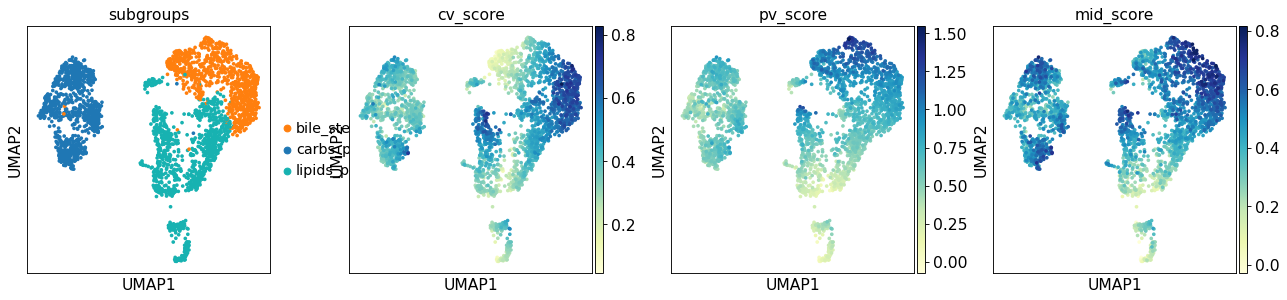

In [12]:
sc.pl.umap(adataH, color=["subgroups","cv_score","pv_score","mid_score"])

In [13]:
annot = []
for idx, elem in enumerate(adataH.obs["cv_score"]):
    if elem > 0.45 and adataH.obs["pv_score"][idx] < 1:
        annot.append("01_pericentral")
    elif elem <= 0.45 and adataH.obs["pv_score"][idx] >= 0.65:
        annot.append("03_periportal")
    else:
        annot.append("02_mid")
adataH.obs["zonation"] = annot

In [14]:
adataH.uns["zonation_colors"] = ["#5b090b",'#a32a4f','#ff5179']

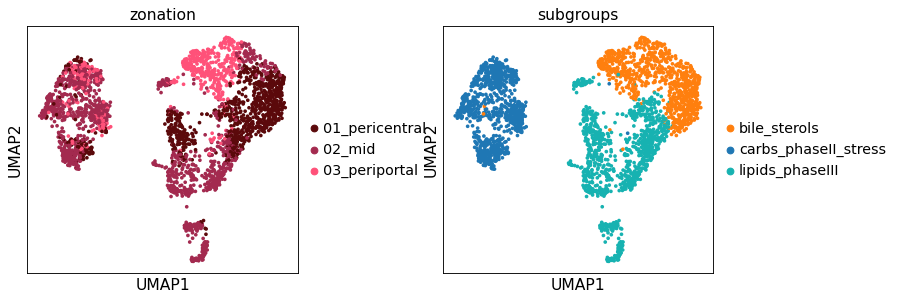

In [199]:
sc.pl.umap(adataH, color=["zonation","subgroups"], ncols=3, wspace=0.4,
          save="_scran_subgroups_zonation_annot_20220215.pdf")

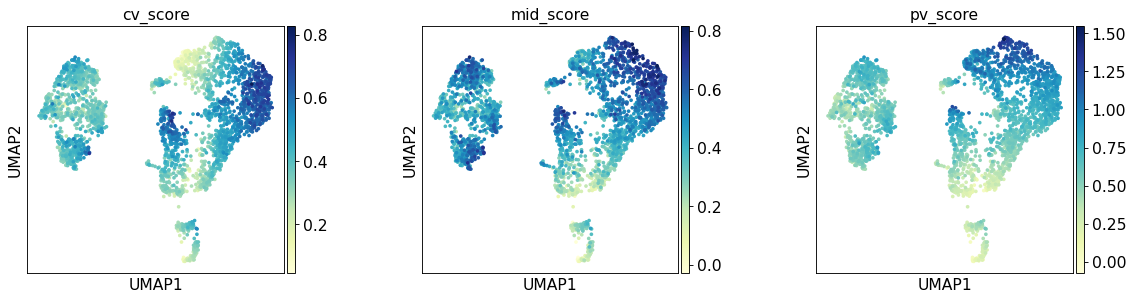

In [200]:
sc.pl.umap(adataH, color=["cv_score","mid_score","pv_score"], ncols=3, wspace=0.4,
          save="_scran_scores_20220215.pdf")

In [16]:
bins = 3
labels = [1,2,3]
adataH.obs["cv_bins"] = pd.cut(adataH.obs["cv_score"], bins=bins, labels=labels)
adataH.obs["pv_bins"] = pd.cut(adataH.obs["pv_score"], bins=bins, labels=labels)
adataH.obs["mid_bins"] = pd.cut(adataH.obs["mid_score"], bins=bins, labels=labels)

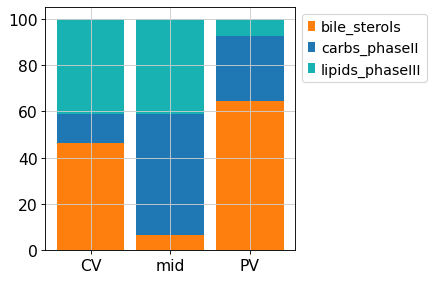

In [17]:
# Data
df = pd.crosstab(adataH.obs["zonation"], adataH.obs["subgroups"], margins = False)
r = np.arange(3)
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['bile_sterols'], df['carbs_phaseII_stress'], df['lipids_phaseIII'])]
B = [i / j * 100 for i,j in zip(df['bile_sterols'], totals)]
C2 = [i / j * 100 for i,j in zip(df['carbs_phaseII_stress'], totals)]
L3 = [i / j * 100 for i,j in zip(df['lipids_phaseIII'], totals)]
# plot
barWidth = 0.85
names = ('CV', 'mid', 'PV')
# Create bars
plt.bar(r, B, width=barWidth, label="bile_sterols", color=("#ff7f0e"))
plt.bar(r, C2, bottom=B, width=barWidth, label="carbs_phaseII", color=("#1f77b4"))
plt.bar(r, L3, bottom=[i+j for i,j in zip(B, C2)], width=barWidth, label="lipids_phaseIII", color=("#17b2b1"))
# Custom x axis
plt.xticks(r, names)
#plt.xlabel("group")
plt.xticks(rotation=0)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
# Show graphic
#plt.savefig("barplot_aizarani_subgroups_zonation_annot_20220215.pdf", bbox_inches="tight")
plt.show()

In [19]:
pd.crosstab(adataH.obs["zonation"], adataH.obs["subgroups"], margins = True)

subgroups,bile_sterols,carbs_phaseII_stress,lipids_phaseIII,All
zonation,,,,
01_pericentral,436,114,388,938
02_mid,86,679,534,1299
03_periportal,326,141,38,505
All,848,934,960,2742


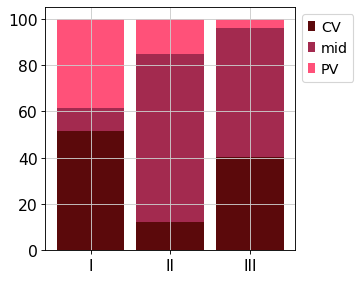

In [203]:
# Data
df = pd.crosstab(adataH.obs["subgroups"], adataH.obs["zonation"], margins = False)
r = np.arange(3)
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['01_pericentral'], df['02_mid'], df['03_periportal'])]
B = [i / j * 100 for i,j in zip(df['01_pericentral'], totals)]
C2 = [i / j * 100 for i,j in zip(df['02_mid'], totals)]
L3 = [i / j * 100 for i,j in zip(df['03_periportal'], totals)]
# plot
barWidth = 0.85
names = ('I', 'II', 'III')
# Create bars
plt.bar(r, B, width=barWidth, label="CV", color=("#5b090b"))
plt.bar(r, C2, bottom=B, width=barWidth, label="mid", color=("#a32a4f"))
plt.bar(r, L3, bottom=[i+j for i,j in zip(B, C2)], width=barWidth, label="PV", color=("#ff5179"))
# Custom x axis
plt.xticks(r, names)
#plt.xlabel("group")
plt.xticks(rotation=0)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
# Show graphic
#plt.savefig("barplot_SCRAN_subgroups_per_zonation_annot_20220128.pdf", bbox_inches="tight")
plt.show()

In [ ]:
adataB = adataH[adataH.obs["subgroups"] == "bile_sterols"]
adataC2 = adataH[adataH.obs["subgroups"] == "carbs_phaseII_stress"]
adataL3 = adataH[adataH.obs["subgroups"] == "lipids_phaseIII"]

In [34]:
for i in [adataB, adataC2, adataL3]:
    sc.tl.score_genes(i, pv, score_name="pv_score")
    sc.tl.score_genes(i, cv, score_name="cv_score")
    sc.tl.score_genes(i, mid, score_name="mid_score")

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


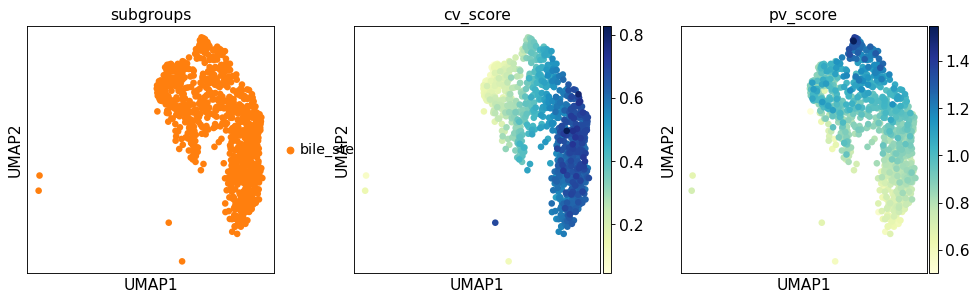

In [214]:
sc.pl.umap(adataB, color=["subgroups","cv_score","pv_score"],
           save="_aizarani_bile_sterols_same_scores_20220215.pdf")

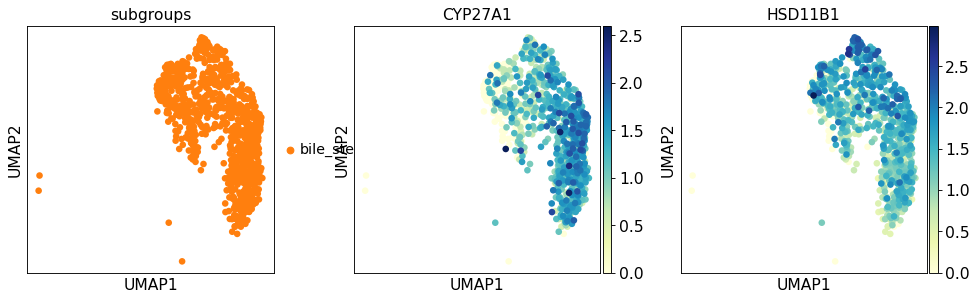

In [215]:
sc.pl.umap(adataB, color=["subgroups","CYP27A1","HSD11B1"],
           save="_aizarani_bile_sterols_same_markers_20220215.pdf")

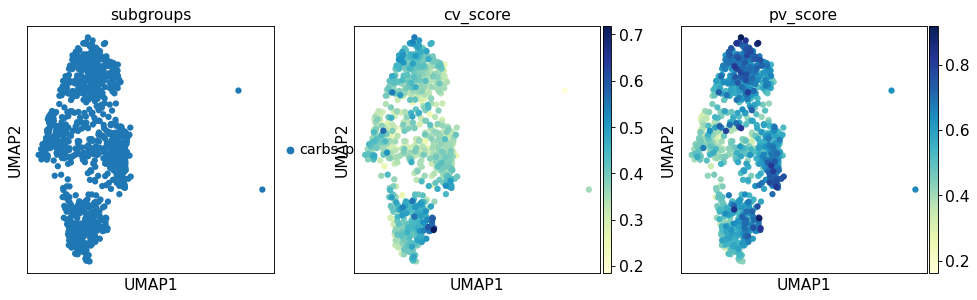

In [216]:
sc.pl.umap(adataC2, color=["subgroups","cv_score","pv_score"],
         save="_aizarani_carbs_phaseII_same_scores_20220215.pdf")

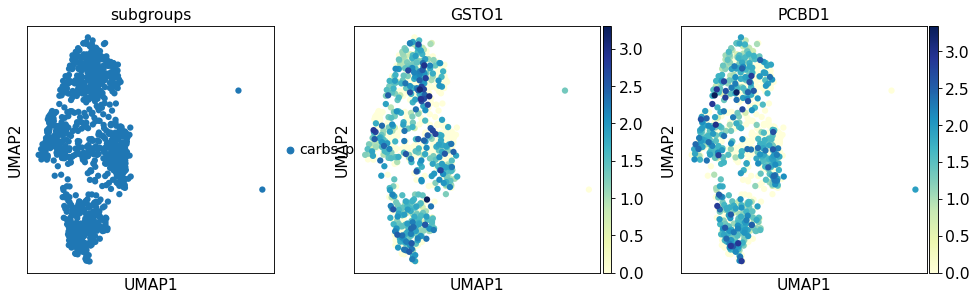

In [217]:
sc.pl.umap(adataC2, color=["subgroups","GSTO1","PCBD1"],
           save="_aizarani_carbs_phaseII_same_markers_20220215.pdf")

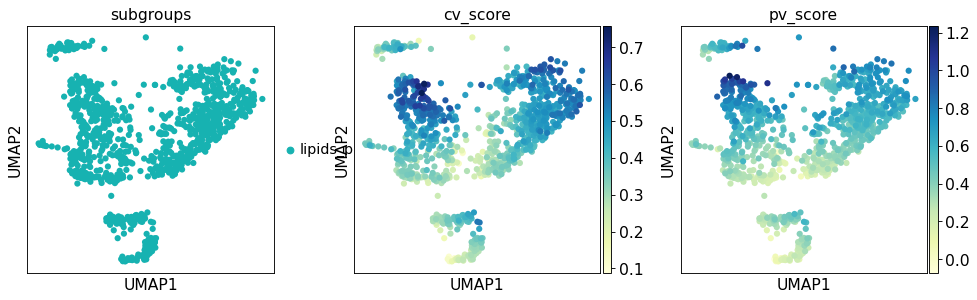

In [218]:
sc.pl.umap(adataL3, color=["subgroups","cv_score","pv_score"],
           save="_aizarani_lipids_phaseIII_same_scores_20220215.pdf")

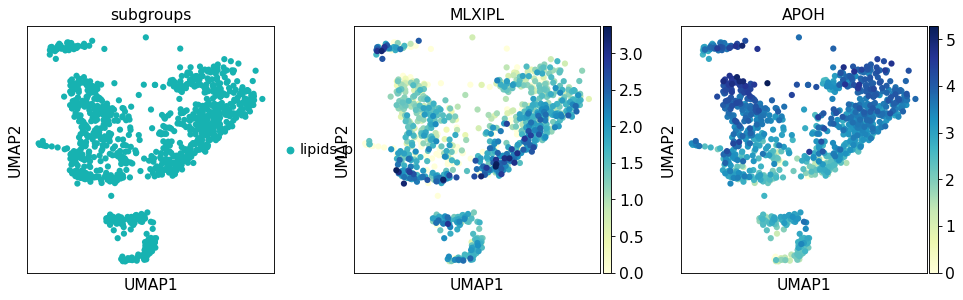

In [219]:
sc.pl.umap(adataL3, color=["subgroups","MLXIPL","APOH"],
           save="_aizarani_lipids_phaseIII_same_markers_20220215.pdf")

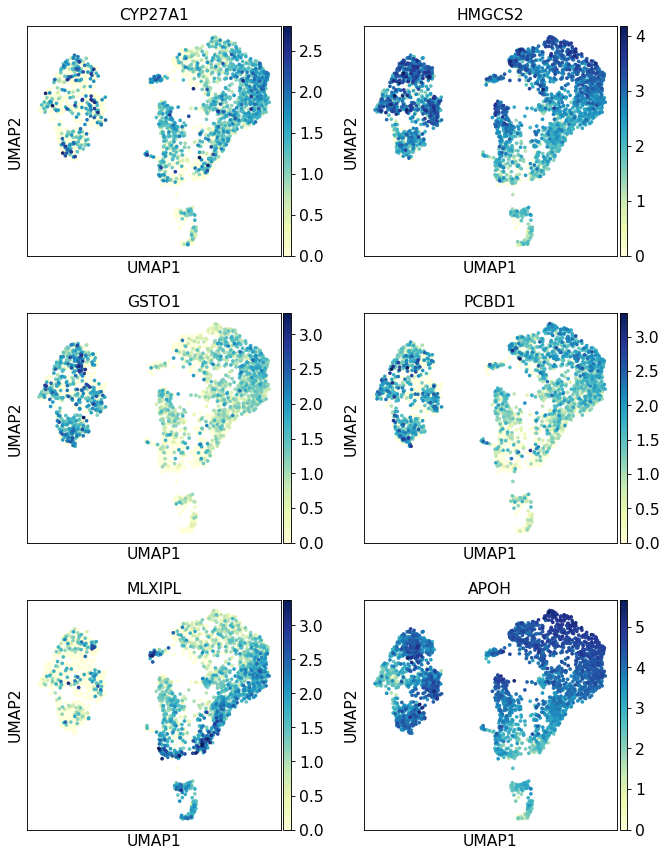

In [220]:
sc.pl.umap(adataH, color=["CYP27A1","HMGCS2","GSTO1","PCBD1","MLXIPL","APOH"], ncols=2,
           save="_aizarani_zonation_markers_subgroups_20220215.pdf")